# Time series forecasting node memory usage

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from parameters import Parameters
from functions import ts_memory, show_plot, plot_ts, univariate_data, ms_val, avg_pred, line_plot

### Import parameters, build and safe df

In [3]:
# import parameters
param = Parameters()
node = 3


# First we create the time-series and save them to a file
# Node to obtain time-series from
node = 3

# Storing the CSV into a DF
results = pd.read_csv("Results.csv")

# Obtain time series of memory usage in node 3
ts = ts_memory(results, node, param)

# Save them to disk
ts.to_pickle('ts.pkl')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:10<00:00, 1413.72it/s]


In [4]:
ts['memory']

0         -196.882922
1          373.269402
2          -71.708071
3          167.805378
4          -65.714010
             ...     
99995    25312.295040
99996    25580.751251
99997    25656.287238
99998    25564.856413
99999    25683.227423
Name: memory, Length: 100000, dtype: float64

## 1 step forecasting

### Plot and preprocess data

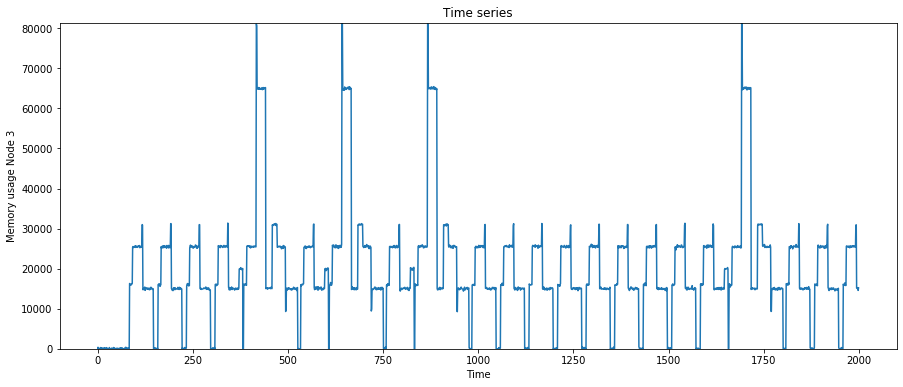

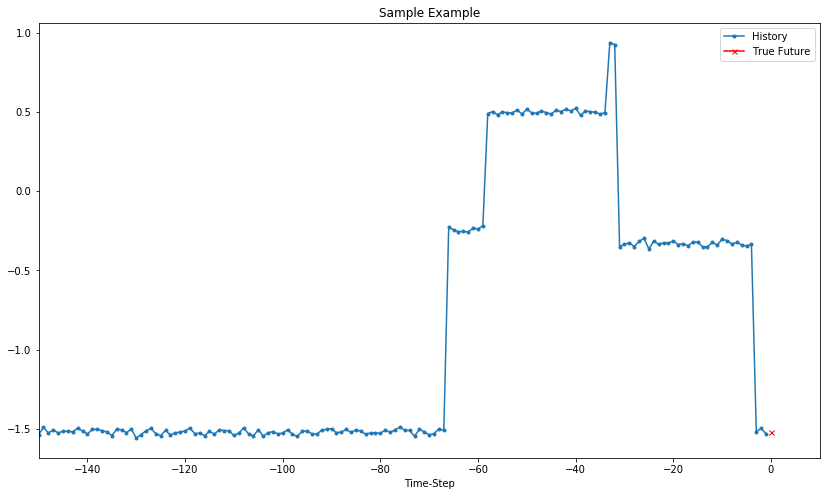

In [5]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 1

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [6]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2162 - val_loss: 0.1747
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1164 - val_loss: 0.0895
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0968 - val_loss: 0.0965
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0990 - val_loss: 0.0900
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0934 - val_loss: 0.0894
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0985 - val_loss: 0.0915
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0937 - val_loss: 0.0900
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0954 - val_loss: 0.0889
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0966 - val_loss: 0.0928
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [8]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

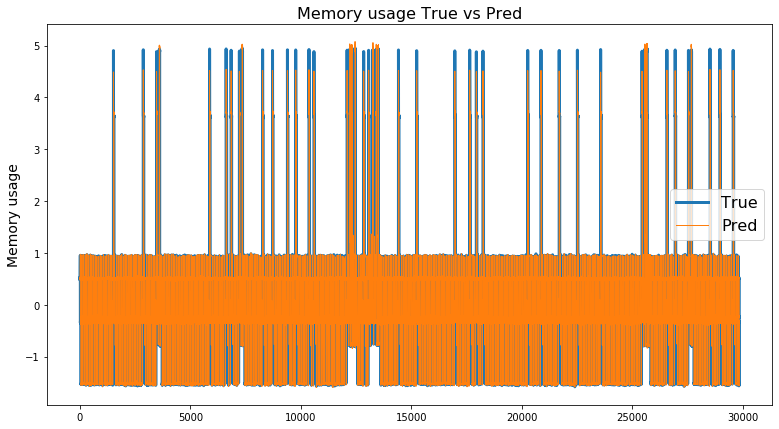

In [9]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

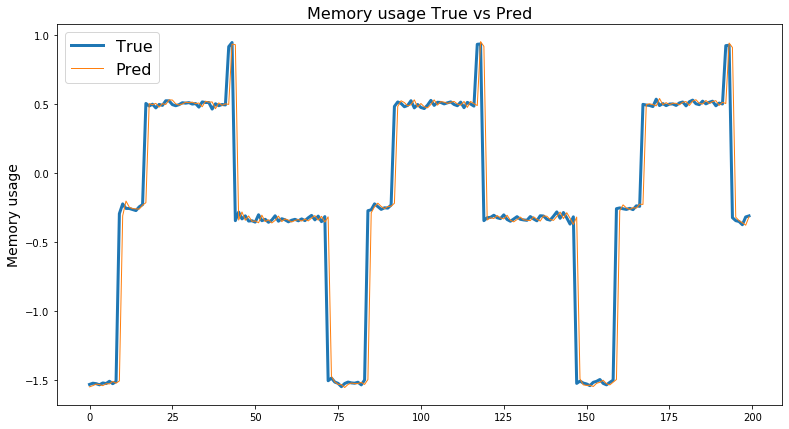

In [10]:
line_plot(y_val_plot.flatten()[800:1000], y_pred.flatten()[800:1000], 'True', 'Pred')

## 5 steps forecasting

### Plot and preprocess data

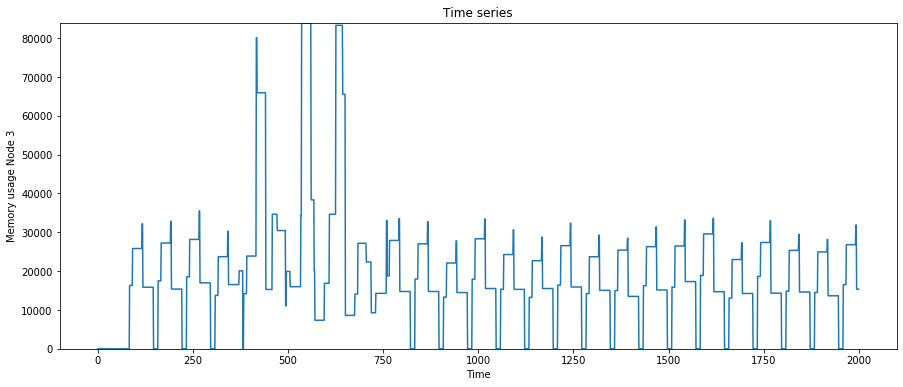

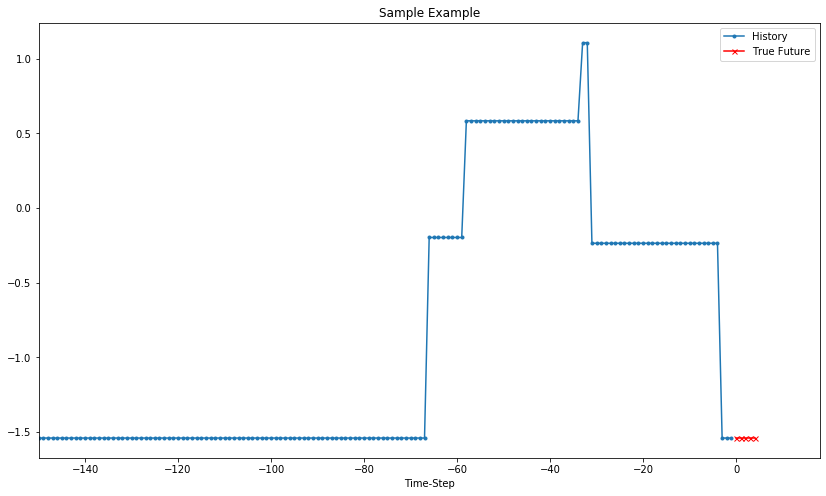

In [11]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 5

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [12]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.3441 - val_loss: 0.2523
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2426 - val_loss: 0.2175
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1962 - val_loss: 0.1974
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1990 - val_loss: 0.1925
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1858 - val_loss: 0.1932
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1725 - val_loss: 0.1748
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1757 - val_loss: 0.1853
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1766 - val_loss: 0.1702
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1773 - val_loss: 0.1661
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Simple LSTM model'))
    

### Predict for val set and plot

In [14]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

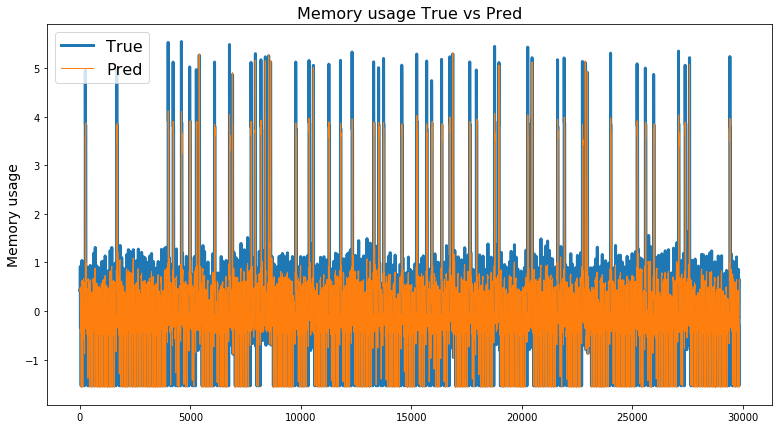

In [15]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

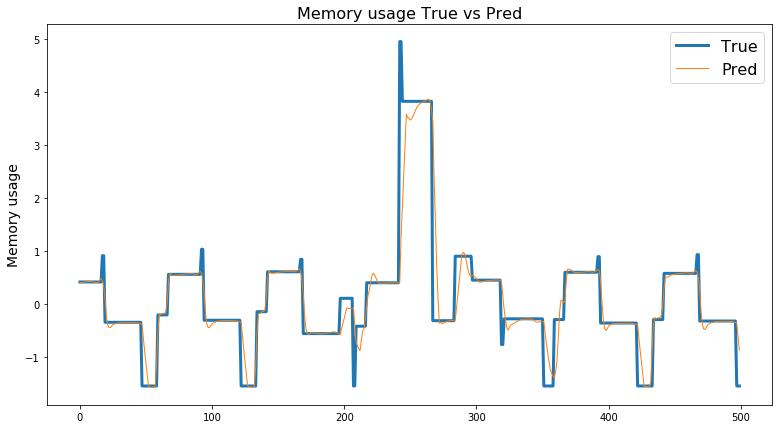

In [16]:
line_plot(y_val_plot.flatten()[:500], y_pred.flatten()[:500], 'True', 'Pred')

## X steps forecasting

### Plot and preprocess data

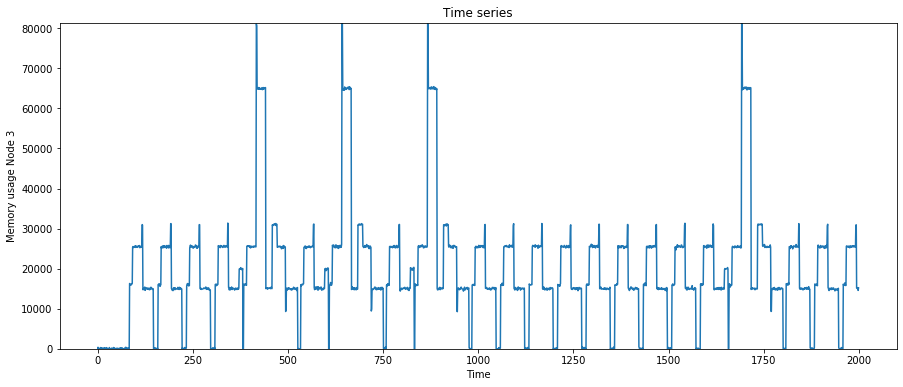

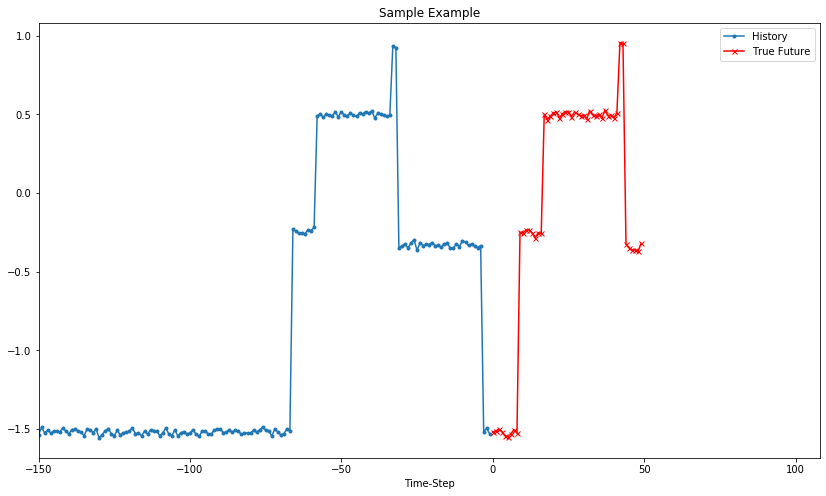

In [11]:
# Use the already saved time-series by loading them from file
ts = pd.read_pickle('ts.pkl')

# Plot time-series
# plot_ts(ts["memory"], node)

# Plot time-series
plot_ts(ts["memory"][:2000], node)

# Set seed for reproducibility
tf.random.set_seed(13)

# Take data
ts_data = ts['memory']
ts_data.index = ts['time']

# We will use 70% percent of data to train
TRAIN_SPLIT = 0.7
TRAIN_SPLIT = int(TRAIN_SPLIT*ts_data.size)

# Normalize data
ts_data_mean = ts_data[:TRAIN_SPLIT].mean()
ts_data_std = ts_data[:TRAIN_SPLIT].std()
ts_data = (ts_data-ts_data_mean) / ts_data_std

# Get the training and validation data and targets
univariate_past_history = 150
univariate_future_target = 50

x_train, y_train = univariate_data(ts_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val, y_val = univariate_data(ts_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

show_plot([x_train[0], y_train[0]], univariate_future_target, 'Sample Example')

### Model

In [12]:
BATCH_SIZE = 100
# BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(univariate_future_target)
])

lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.4589 - val_loss: 0.2930
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3433 - val_loss: 0.2399
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2992 - val_loss: 0.2243
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3030 - val_loss: 0.2004
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2328 - val_loss: 0.1968
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3164 - val_loss: 0.2247
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2449 - val_loss: 0.1956
Epoch 8/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2605 - val_loss: 0.1781
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.2498 - val_loss: 0.1799
Epoch 10/10
200/200 [===========================

### Plot results

In [ ]:
for x, y in val_univariate:
    plot = []
    for i in range(len(x)):
        plot.append(show_plot([x[i].numpy(), y[i].numpy(),
                        lstm_model.predict(x)[i]], univariate_future_target, 'Memory usage True vs pred'))
    

### Predict for val set and plot

In [14]:
y_pred = lstm_model.predict(x_val)

y_val_plot = ms_val(y_val)
y_pred = avg_pred(y_pred)

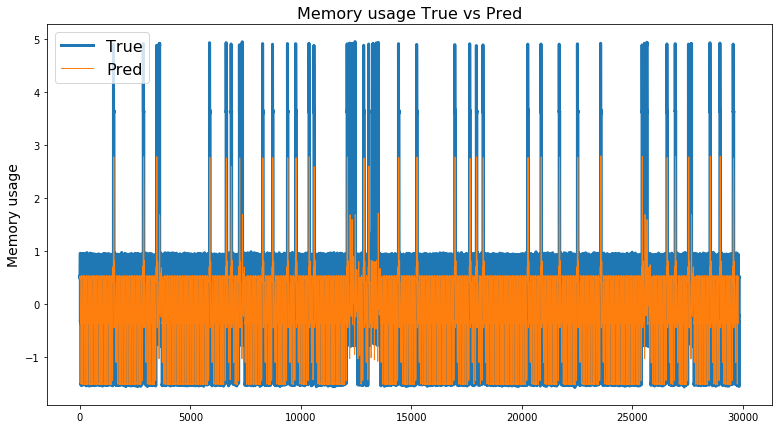

In [15]:
line_plot(y_val_plot.flatten(), y_pred.flatten(), 'True', 'Pred')

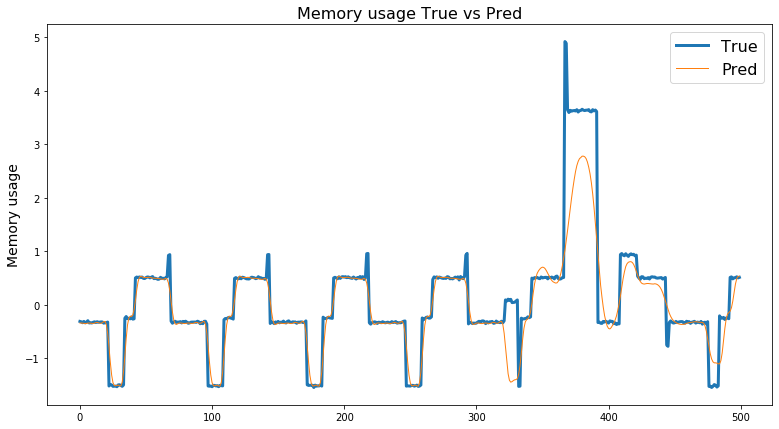

In [16]:
line_plot(y_val_plot.flatten()[10000:10500], y_pred.flatten()[10000:10500], 'True', 'Pred')